### **Download & Unzip**

In [ ]:
!wget https://s3.bonescreen.de/public/VerSe-complete/dataset-verse20training.zip
!unzip /content/dataset-verse20training.zip

### **Data utilities (必須先執行)**
ref：https://github.com/anjany/verse/blob/main/utils/data_utilities.py

In [2]:
!pip install nibabel==3.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [3]:
"""data_utilities.py: Everything data-related for VerSe."""

__author__      = "Maximilian T. Löffler, Malek El Husseini"


from pathlib import Path
from numpy.core.numeric import NaN
import numpy as np
import nibabel as nib
import nibabel.processing as nip
import nibabel.orientations as nio
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Circle
import json


v_dict = {
    1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7',
    8: 'T1', 9: 'T2', 10: 'T3', 11: 'T4', 12: 'T5', 13: 'T6', 14: 'T7',
    15: 'T8', 16: 'T9', 17: 'T10', 18: 'T11', 19: 'T12', 20: 'L1',
    21: 'L2', 22: 'L3', 23: 'L4', 24: 'L5', 25: 'L6', 26: 'Sacrum',
    27: 'Cocc', 28: 'T13'
}

colors_itk = (1/255)*np.array([
    [255,  0,  0], [  0,255,  0], [  0,  0,255], [255,255,  0], [  0,255,255],
    [255,  0,255], [255,239,213],  # Label 1-7 (C1-7)
    [  0,  0,205], [205,133, 63], [210,180,140], [102,205,170], [  0,  0,128],
    [  0,139,139], [ 46,139, 87], [255,228,225], [106, 90,205], [221,160,221],
    [233,150,122], [165, 42, 42],  # Label 8-19 (T1-12)
    [255,250,250], [147,112,219], [218,112,214], [ 75,  0,130], [255,182,193],
    [ 60,179,113], [255,235,205],  # Label 20-26 (L1-6, sacrum)
    [255,235,205], [255,228,196],  # Label 27 cocc, 28 T13,
    [218,165, 32], [  0,128,128], [188,143,143], [255,105,180],  
    [255,  0,  0], [  0,255,  0], [  0,  0,255], [255,255,  0], [  0,255,255],
    [255,  0,255], [255,239,213],  # 29-39 unused
    [  0,  0,205], [205,133, 63], [210,180,140], [102,205,170], [  0,  0,128],
    [  0,139,139], [ 46,139, 87], [255,228,225], [106, 90,205], [221,160,221],
    [233,150,122],   # Label 40-50 (subregions)
    [255,250,250], [147,112,219], [218,112,214], [ 75,  0,130], [255,182,193],
    [ 60,179,113], [255,235,205], [255,105,180], [165, 42, 42], [188,143,143],
    [255,235,205], [255,228,196], [218,165, 32], [  0,128,128] # rest unused     
    ])
cm_itk = ListedColormap(colors_itk)
cm_itk.set_bad(color='w', alpha=0)  # set NaN to full opacity for overlay

# define HU windows
wdw_sbone = Normalize(vmin=-500, vmax=1300, clip=True)
wdw_hbone = Normalize(vmin=-200, vmax=1000, clip=True)

#########################
# Resample and reorient #


def reorient_to(img, axcodes_to=('P', 'I', 'R'), verb=False):
    """Reorients the nifti from its original orientation to another specified orientation
    
    Parameters:
    ----------
    img: nibabel image
    axcodes_to: a tuple of 3 characters specifying the desired orientation
    
    Returns:
    ----------
    newimg: The reoriented nibabel image 
    
    """
    aff = img.affine
    arr = np.asanyarray(img.dataobj, dtype=img.dataobj.dtype)
    ornt_fr = nio.io_orientation(aff)
    ornt_to = nio.axcodes2ornt(axcodes_to)
    ornt_trans = nio.ornt_transform(ornt_fr, ornt_to)
    arr = nio.apply_orientation(arr, ornt_trans)
    aff_trans = nio.inv_ornt_aff(ornt_trans, arr.shape)
    newaff = np.matmul(aff, aff_trans)
    newimg = nib.Nifti1Image(arr, newaff)
    if verb:
        print("[*] Image reoriented from", nio.ornt2axcodes(ornt_fr), "to", axcodes_to)
    return newimg


def resample_nib(img, voxel_spacing=(1, 1, 1), order=3):
    """Resamples the nifti from its original spacing to another specified spacing
    
    Parameters:
    ----------
    img: nibabel image
    voxel_spacing: a tuple of 3 integers specifying the desired new spacing
    order: the order of interpolation
    
    Returns:
    ----------
    new_img: The resampled nibabel image 
    
    """
    # resample to new voxel spacing based on the current x-y-z-orientation
    aff = img.affine
    shp = img.shape
    zms = img.header.get_zooms()
    # Calculate new shape
    new_shp = tuple(np.rint([
        shp[0] * zms[0] / voxel_spacing[0],
        shp[1] * zms[1] / voxel_spacing[1],
        shp[2] * zms[2] / voxel_spacing[2]
        ]).astype(int))
    new_aff = nib.affines.rescale_affine(aff, shp, voxel_spacing, new_shp)
    new_img = nip.resample_from_to(img, (new_shp, new_aff), order=order, cval=-1024)
    print("[*] Image resampled to voxel size:", voxel_spacing)
    return new_img


def resample_mask_to(msk, to_img):
    """Resamples the nifti mask from its original spacing to a new spacing specified by its corresponding image
    
    Parameters:
    ----------
    msk: The nibabel nifti mask to be resampled
    to_img: The nibabel image that acts as a template for resampling
    
    Returns:
    ----------
    new_msk: The resampled nibabel mask 
    
    """
    to_img.header['bitpix'] = 8
    to_img.header['datatype'] = 2  # uint8
    new_msk = nib.processing.resample_from_to(msk, to_img, order=0)
    print("[*] Mask resampled to image size:", new_msk.header.get_data_shape())
    return new_msk


def get_plane(img_path):
    """Gets the plane of the highest resolution from a nifti file
    
    Parameters:
    ----------
    img_path: the full path to the nifti file
    
    Returns:
    ----------
    plane: a string corresponding to the plane of highest resolution
    
    """
    plane_dict = {
        'S': 'ax', 'I': 'ax', 'L': 'sag', 'R': 'sag', 'A': 'cor', 'P': 'cor'}
    img = nib.load(str(img_path))
    axc = np.array(nio.aff2axcodes(img.affine))
    zms = np.around(img.header.get_zooms(), 1)
    ix_max = np.array(zms == np.amax(zms))
    num_max = np.count_nonzero(ix_max)
    if num_max == 2:
        plane = plane_dict[axc[~ix_max][0]]
    elif num_max == 1:
        plane = plane_dict[axc[ix_max][0]]
    else:
        plane = 'iso'
    return plane


######################
# Handling centroids #

def load_centroids(ctd_path):
    """loads the json centroid file
    
    Parameters:
    ----------
    ctd_path: the full path to the json file
    
    Returns:
    ----------
    ctd_list: a list containing the orientation and coordinates of the centroids
    
    """
    with open(ctd_path) as json_data:
        dict_list = json.load(json_data)
        json_data.close()
    ctd_list = []
    for d in dict_list:
        if 'direction' in d:
            ctd_list.append(tuple(d['direction']))
        elif 'nan' in str(d):            #skipping NaN centroids
            continue
        else:
            ctd_list.append([d['label'], d['X'], d['Y'], d['Z']]) 
    return ctd_list


def centroids_to_dict(ctd_list):
    """Converts the centroid list to a dictionary of centroids
    
    Parameters:
    ----------
    ctd_list: the centroid list
    
    Returns:
    ----------
    dict_list: a dictionart of centroids having the format dict[vertebra] = ['X':x, 'Y':y, 'Z': z]
    
    """
    dict_list = []
    for v in ctd_list:
        if any('nan' in str(v_item) for v_item in v): continue   #skipping invalid NaN values
        v_dict = {}
        if isinstance(v, tuple):
            v_dict['direction'] = v
        else:
            v_dict['label'] = int(v[0])
            v_dict['X'] = v[1]
            v_dict['Y'] = v[2]
            v_dict['Z'] = v[3]
        dict_list.append(v_dict)
    return dict_list


def save_centroids(ctd_list, out_path):
    """Saves the centroid list to json file
    
    Parameters:
    ----------
    ctd_list: the centroid list
    out_path: the full desired save path
    
    """
    if len(ctd_list) < 2:
        print("[#] Centroids empty, not saved:", out_path)
        return
    json_object = centroids_to_dict(ctd_list)
    # Problem with python 3 and int64 serialisation.
    def convert(o):
        if isinstance(o, np.int64):
            return int(o)
        raise TypeError
    with open(out_path, 'w') as f:
        json.dump(json_object, f, default=convert)
    print("[*] Centroids saved:", out_path)


def calc_centroids(msk, decimals=1, world=False):
    """Gets the centroids from a nifti mask by calculating the centers of mass of each vertebra
    
    Parameters:
    ----------
    msk: nibabel nifti mask
    decimals: rounds the coordinates x decimal digits
    
    Returns:
    ----------
    ctd_list: list of centroids 
    
    """
    msk_data = np.asanyarray(msk.dataobj, dtype=msk.dataobj.dtype)
    axc = nio.aff2axcodes(msk.affine)
    ctd_list = [axc]
    verts = np.unique(msk_data)[1:]
    verts = verts[~np.isnan(verts)]  # remove NaN values
    for i in verts:
        msk_temp = np.zeros(msk_data.shape, dtype=bool)
        msk_temp[msk_data == i] = True
        ctr_mass = center_of_mass(msk_temp)
        if world:
            ctr_mass = msk.affine[:3, :3].dot(ctr_mass) + msk.affine[:3, 3]
            ctr_mass = ctr_mass.tolist()
        ctd_list.append([i] + [round(x, decimals) for x in ctr_mass])
    return ctd_list


def reorient_centroids_to(ctd_list, img, decimals=1, verb=False):
    """reorient centroids to image orientation
    
    Parameters:
    ----------
    ctd_list: list of centroids
    img: nibabel image 
    decimals: rounding decimal digits
    
    Returns:
    ----------
    out_list: reoriented list of centroids 
    
    """
    ctd_arr = np.transpose(np.asarray(ctd_list[1:]))
    if len(ctd_arr) == 0:
        print("[#] No centroids present") 
        return ctd_list
    v_list = ctd_arr[0].astype(int).tolist()  # vertebral labels
    ctd_arr = ctd_arr[1:]
    ornt_fr = nio.axcodes2ornt(ctd_list[0])  # original centroid orientation
    axcodes_to = nio.aff2axcodes(img.affine)
    ornt_to = nio.axcodes2ornt(axcodes_to)
    trans = nio.ornt_transform(ornt_fr, ornt_to).astype(int)
    perm = trans[:, 0].tolist()
    shp = np.asarray(img.dataobj.shape)
    ctd_arr[perm] = ctd_arr.copy()
    for ax in trans:
        if ax[1] == -1:
            size = shp[ax[0]]
            ctd_arr[ax[0]] = np.around(size - ctd_arr[ax[0]], decimals)
    out_list = [axcodes_to]
    ctd_list = np.transpose(ctd_arr).tolist()
    for v, ctd in zip(v_list, ctd_list):
        out_list.append([v] + ctd)
    if verb:
        print("[*] Centroids reoriented from", nio.ornt2axcodes(ornt_fr), "to", axcodes_to)
    return out_list


def rescale_centroids(ctd_list, img, voxel_spacing=(1, 1, 1)):
    """rescale centroid coordinates to new spacing in current x-y-z-orientation
    
    Parameters:
    ----------
    ctd_list: list of centroids
    img: nibabel image 
    voxel_spacing: desired spacing
    
    Returns:
    ----------
    out_list: rescaled list of centroids 
    
    """
    ornt_img = nio.io_orientation(img.affine)
    ornt_ctd = nio.axcodes2ornt(ctd_list[0])
    if np.array_equal(ornt_img, ornt_ctd):
        zms = img.header.get_zooms()
    else:
        ornt_trans = nio.ornt_transform(ornt_img, ornt_ctd)
        aff_trans = nio.inv_ornt_aff(ornt_trans, img.dataobj.shape)
        new_aff = np.matmul(img.affine, aff_trans)
        zms = nib.affines.voxel_sizes(new_aff)
    ctd_arr = np.transpose(np.asarray(ctd_list[1:]))
    v_list = ctd_arr[0].astype(int).tolist()  # vertebral labels
    ctd_arr = ctd_arr[1:]
    ctd_arr[0] = np.around(ctd_arr[0] * zms[0] / voxel_spacing[0], decimals=1)
    ctd_arr[1] = np.around(ctd_arr[1] * zms[1] / voxel_spacing[1], decimals=1)
    ctd_arr[2] = np.around(ctd_arr[2] * zms[2] / voxel_spacing[2], decimals=1)
    out_list = [ctd_list[0]]
    ctd_list = np.transpose(ctd_arr).tolist()
    for v, ctd in zip(v_list, ctd_list):
        out_list.append([v] + ctd)
    print("[*] Rescaled centroid coordinates to spacing (x, y, z) =", voxel_spacing, "mm")
    return out_list

def create_figure(dpi, *planes):
    """creates a matplotlib figure
    
    Parameters:
    ----------
    dpi: desired dpi
    *planes: numpy arrays to include in the figure 
    
    Returns:
    ----------
    fig, axs
    
    """
    fig_h = round(2 * planes[0].shape[0] / dpi, 2)
    plane_w = [p.shape[1] for p in planes]
    w = sum(plane_w)
    fig_w = round(2 * w / dpi, 2)
    x_pos = [0]
    for x in plane_w[:-1]:
        x_pos.append(x_pos[-1] + x)
    fig, axs = plt.subplots(1, len(planes), figsize=(fig_w, fig_h))
    for a in axs:
        a.axis('off')
        idx = axs.tolist().index(a)
        a.set_position([x_pos[idx]/w, 0, plane_w[idx]/w, 1])
    return fig, axs


def plot_sag_centroids(axs, ctd, zms):
    """plots sagittal centroids on a plane axes
    
    Parameters:
    ----------
    axs: matplotlib axs
    ctd: list of centroids
    zms: the spacing of the image
    """
    # requires v_dict = dictionary of mask labels
    for v in ctd[1:]:
        axs.add_patch(Circle((v[2]*zms[1], v[1]*zms[0]), 2, color=colors_itk[v[0]-1]))
        axs.text(4, v[1]*zms[0], v_dict[v[0]], fontdict={'color': cm_itk(v[0]-1), 'weight': 'bold'})


def plot_cor_centroids(axs, ctd, zms):
    """plots coronal centroids on a plane axes
    
    Parameters:
    ----------
    axs: matplotlib axs
    ctd: list of centroids
    zms: the spacing of the image
    """
    # requires v_dict = dictionary of mask labels
    for v in ctd[1:]:
        axs.add_patch(Circle((v[3]*zms[2], v[1]*zms[0]), 2, color=colors_itk[v[0]-1]))
        axs.text(4, v[1]*zms[0], v_dict[v[0]], fontdict={'color': cm_itk(v[0]-1), 'weight': 'bold'})

### **Prepare Data (略)**
(此為測試 不需執行)<br>
ref：https://github.com/anjany/verse/blob/main/utils/prepare_data.ipynb

img zooms = (0.8730469, 0.8730469, 0.9)
img orientation code: ('L', 'A', 'S')
Centroid List: [('L', 'A', 'S'), [7, 270.9, 217.9, 731.4], [8, 273.4, 204.9, 711.7], [9, 274.2, 192.4, 691.6], [10, 272.3, 180.1, 671.2], [11, 270.3, 170.9, 648.5], [12, 267.8, 163.2, 624.1], [13, 265.8, 158.3, 598.7], [14, 263.9, 156.3, 571.8], [15, 261.3, 157.6, 544.0], [16, 258.7, 160.7, 516.1], [17, 256.9, 164.3, 486.2], [18, 256.6, 169.6, 455.3], [19, 258.2, 176.8, 420.6], [20, 260.0, 186.7, 383.5], [21, 260.5, 196.9, 344.0], [22, 260.7, 205.2, 304.2], [23, 259.8, 210.6, 263.0], [24, 258.7, 208.0, 222.2]]
[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [7, 20.7, 256.8, 236.5], [8, 38.5, 268.1, 238.7], [9, 56.6, 279.0, 239.4], [10, 74.9, 289.8, 237.7], [11, 95.4, 297.8, 236.0], [12, 117.3, 304.5, 2

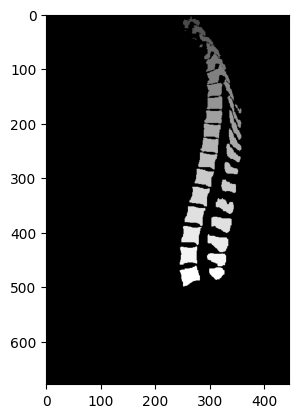

447


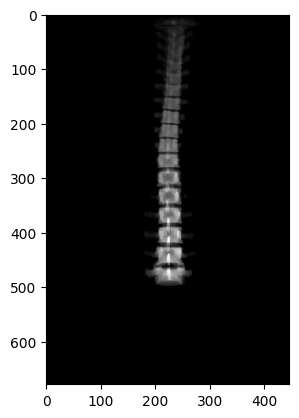

In [ ]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt

DATA_INDEX = 2

# data directory
msk_path = [
    "/content/dataset-01training/derivatives/sub-gl003",
    "/content/dataset-01training/derivatives/sub-verse500/",
    "/content/dataset-01training/derivatives/sub-verse646/"
]
raw_path = [
    "/content/dataset-01training/rawdata/sub-gl003/sub-gl003_dir-ax_ct.nii.gz",
    "/content/dataset-01training/rawdata/sub-verse500/sub-verse500_dir-ax_ct.nii.gz",
    "/content/dataset-01training/rawdata/sub-verse646/sub-verse646_dir-iso_ct.nii.gz"
]

# load files
files = os.listdir(msk_path[DATA_INDEX])
for file_name in files:
    if ".nii.gz" in file_name:
        msk_nib = nib.load(os.path.join(msk_path[DATA_INDEX], file_name))
    elif ".json" in file_name:
        ctd_list = load_centroids(os.path.join(msk_path[DATA_INDEX], file_name))
img_nib = nib.load(raw_path[DATA_INDEX])



# check img zooms
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

# check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

# check centroids
print('Centroid List: {}'.format(ctd_list))



# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0)  # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

# check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

# check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

# check centroids
print('new centroids: {}'.format(ctd_iso))



# get vocel data
img_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()

# 找到適當的分界點
lookFromSide = msk_np[:, :, msk_np.shape[2]//2]
plt.imshow(lookFromSide, cmap='gray')
plt.show()

def find_split_point(img):
    Down_flag = False
    Up_flag = False
    sums = [0, 0, 0, 0]
    for x in range(img.shape[1]):  # 從左到右 一縱行一縱行的計算
        sums[0] = sums[1]
        sums[1] = sums[2]
        sums[2] = sums[3]
        sums[3] = 0
        for y in range(img.shape[0]):
            sums[3] += img[y, x]
        
        if int(np.mean(sums[2:3])) > int(np.mean(sums[0:2])):
            if not Up_flag:
                Up_flag = True
            elif Down_flag:
                return x
        elif Up_flag and int(np.mean(sums[2:3])) < int(np.mean(sums[0:2]) * 0.9):
            Down_flag = True
    return 0

# split_index = find_split_point(lookFromSide)
split_index = msk_np.shape[1]
print(split_index)

raw_proj = np.sum(img_np[:, :, :], axis=1)
msk_proj = np.sum(msk_np[:, :split_index, :], axis=1)

# 顯示結果
plt.imshow(msk_proj, cmap='gray')
plt.show()

# 儲存結果為.png檔案
plt.imsave('msk_image.png', msk_proj, cmap='gray')
plt.imsave('raw_image.png', raw_proj, cmap='gray')

### **Keypoints detect (法1：by using only one pic)**

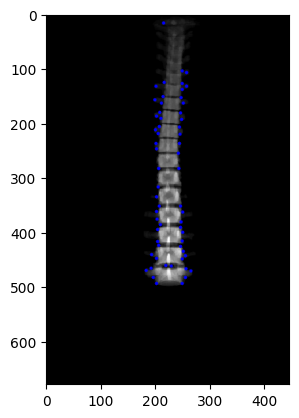

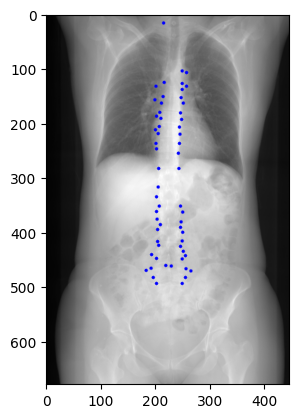

In [ ]:
### Keypoints Plot
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# 讀取圖片
img = cv2.imread("/content/msk_image.png")
raw_img = cv2.imread("/content/raw_image.png")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray, (3, 3))

def sigmoid_brightness(img):
    # 將圖像標準化到 (-5, 5) 範圍内
    img_norm = (img - np.mean(img)) / np.std(img)

    # 使用 sigmoid 函数对灰度图像进行调整
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    img = 255 * sigmoid(10 * (img_norm - 0.5))
    return np.array(img, dtype=np.uint8)

gray = sigmoid_brightness(gray)

# 使用cv2.cornerHarris()方法進行角點偵測
block_size = 7
ksize = 7
k = 0.04
threshold = 0.3

dst = cv2.cornerHarris(gray, block_size, ksize, k)
dst = cv2.dilate(dst, None)

# 過濾關鍵點
feature_points = []
threshold = threshold * dst.max()
for x in range(dst.shape[0]):
    for y in range(dst.shape[1]):
        if dst[x, y] > threshold:
            feature_points.append([x, y])

def merge_close_points(coords, r):
    """
    將距離小於 r 的座標平均起來
    """
    points = np.array(coords)
    merged_points = []  # 儲存合併後的座標
    num_points = len(points)
    visited = np.zeros(num_points)  # 標記已經合併的座標

    for i in range(num_points):
        if visited[i]:  # 如果已經合併過，跳過
            continue
        
        # 找到所有距離小於 r 的座標
        merge_indices = [i]
        for j in range(i+1, num_points):
            if visited[j]:  # 如果已經合併過，跳過
                continue
            dist = np.linalg.norm(np.array(points[i]) - np.array(points[j]))  # 計算距離
            if dist < r:
                merge_indices.append(j)
        
        # 計算這些座標的平均值
        merged_point = np.mean(np.array(points[merge_indices]), axis=0)
        merged_points.append(merged_point.astype(int))  # 將平均座標轉換為整數座標
        visited[merge_indices] = 1  # 標記已經合併的座標

    return merged_points

true_points = merge_close_points(feature_points, 8)
true_points = merge_close_points(true_points, 8)

def final_check(img, points, threshold):
    """
    移除一些看起來不像關鍵點的點 (算了)
    """
    lap_filter = np.array([1, 1, 1, -1, -1, -1])
    high = []
    low = []
    for coord in points:
        line1 = np.array([
            img[coord[0]-3, coord[1]-3],
            img[coord[0]-2, coord[1]-2],
            img[coord[0]-1, coord[1]-1],
            img[coord[0]+1, coord[1]+1],
            img[coord[0]+2, coord[1]+2],
            img[coord[0]+3, coord[1]+3]
        ])

        line2 = np.array([
            img[coord[0]-3, coord[1]+3],
            img[coord[0]-2, coord[1]+2],
            img[coord[0]-1, coord[1]+1],
            img[coord[0]+1, coord[1]-1],
            img[coord[0]+2, coord[1]-2],
            img[coord[0]+3, coord[1]-3]
        ])

        num1 = abs(np.inner(line1, lap_filter))
        num2 = abs(np.inner(line2, lap_filter))

        if num1 >= num2:
            high.append(num1)
            low.append(num2)
        else:
            high.append(num2)
            low.append(num1)
    
    new_points = []
    dif = np.array(high) - np.array(low)
    for i in range(len(points)):
        if dif[i] > np.mean(dif) * threshold:
            new_points.append(points[i])
    return new_points

# true_points = final_check(gray, true_points, 0.1)

# 輸出圖像
for coord in true_points:
    cv2.circle(img, (coord[1], coord[0]), 3, (0, 0, 255), -1)
    cv2.circle(raw_img, (coord[1], coord[0]), 3, (0, 0, 255), -1)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(raw_img, cmap='gray')
plt.show()

### **Keypoints detect (法2：by using NIFTI file)**

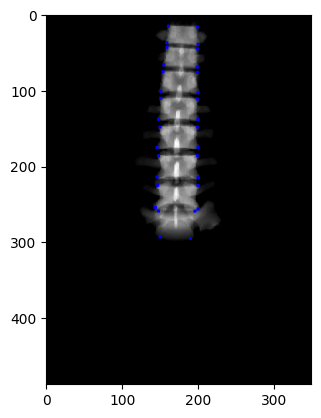

In [27]:
import os
import time
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt


# data directory (改DATA_INDEX就好)
DATA_INDEX = "500"

MSK_ROOT = "/content/dataset-01training/derivatives"
RAW_ROOT = "/content/dataset-01training/rawdata"


def norm_np_img(img_arr):
    norm_data = []
    for pix in img_arr:
        pix_norm = wdw_sbone(pix)
        norm_data.append(pix_norm)
    return np.array(norm_data)


subdirs = os.listdir(MSK_ROOT)
for dir in subdirs:
    if DATA_INDEX in dir:
        msk_path = os.path.join(MSK_ROOT, dir)
subdirs = os.listdir(RAW_ROOT)
for dir in subdirs:
    if DATA_INDEX in dir:
        files = os.listdir(os.path.join(RAW_ROOT, dir))
        for file_name in files:
            if ".nii.gz" in file_name:
                raw_path = os.path.join(RAW_ROOT, dir, file_name)

# load files
files = os.listdir(msk_path)
for file_name in files:
    if ".nii.gz" in file_name:
        msk_nib = nib.load(os.path.join(msk_path, file_name))
    elif ".json" in file_name:
        ctd_list = load_centroids(os.path.join(msk_path, file_name))
img_nib = nib.load(raw_path)

# check img zooms
zooms = img_nib.header.get_zooms()
print('img zooms = {}'.format(zooms))

# check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
print('img orientation code: {}'.format(axs_code))

# check centroids
print('Centroid List: {}'.format(ctd_list))

# Resample and Reorient data
img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0)  # or resample based on img: resample_mask_to(msk_nib, img_iso)
ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

# check img zooms 
zooms = img_iso.header.get_zooms()
print('img zooms = {}'.format(zooms))

# check img orientation
axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
print('img orientation code: {}'.format(axs_code))

# check centroids
print('new centroids: {}'.format(ctd_iso))

# get vocel data
img_np  = img_iso.get_fdata()
msk_np = msk_iso.get_fdata()

# 儲存人體正視圖
raw_proj = np.sum(img_np, axis=1)
plt.imsave('raw_image_withoutNorm.png', raw_proj, cmap='gray')
raw_proj = np.sum(norm_np_img(img_np), axis=1)
plt.imsave('raw_image_Norm.png', raw_proj, cmap='gray')



from IPython.display import clear_output
import cv2

def next():
    time.sleep(0.8)
    # input("Press 'Enter' key to show next:\n")
    clear_output(wait=True)

### 依照重要切片找尋關鍵點
keyPt = []
count = [10000, 10000, 10000, 10000]

# ('P', 'S', 'R') = (前-後, 上-下, 左-右);  ('I', 'P', 'L') = (下, 後, 左)
ud = 1  # 上下
ap = 2  # 前後
lr = 3  # 左右

msk_np[msk_np > 0] = 1
msk_np[msk_np < 1] = 0

for i in range(len(ctd_iso)-1):
    # 側視切片
    msk_proj = msk_np[:, :, int(ctd_iso[i+1][lr])]  # ctd_iso[i][3] = "L"
    color_img = np.stack([ msk_proj, msk_proj, msk_proj ], axis=-1)
    color_img[
        int(ctd_iso[i+1][ud])-2 : int(ctd_iso[i+1][ud])+2,
        int(ctd_iso[i+1][ap])-2 : int(ctd_iso[i+1][ap])+2
    ] = [0, 0, 255]
    plt.imshow(color_img)
    plt.show()

    # 找尋關鍵點
    msk_proj = msk_np[:, int(ctd_iso[i+1][ap]), :]  # ctd_iso[i][2] = "P"
    pts = [
        ctd_iso[i+1][0],  # 第幾節脊柱
        [int(ctd_iso[i+1][ud]), int(ctd_iso[i+1][lr])],  # 左上關鍵點
        [int(ctd_iso[i+1][ud]), int(ctd_iso[i+1][lr])],  # 左下關鍵點
        [int(ctd_iso[i+1][ud]), int(ctd_iso[i+1][lr])],  # 右上關鍵點
        [int(ctd_iso[i+1][ud]), int(ctd_iso[i+1][lr])],  # 右下關鍵點
        [int(ctd_iso[i+1][ud]), int(ctd_iso[i+1][lr])]   # 中心點
    ]
    ct = 0
    while msk_proj[pts[1][0]-2, pts[1][1]] > 0 or msk_proj[pts[1][0], pts[1][1]-2] > 0 and ct < np.mean(count):
        ct += 1
        if msk_proj[pts[1][0]-2, pts[1][1]] > 0: pts[1][0] -= 1  # 上
        if msk_proj[pts[1][0], pts[1][1]-2] > 0: pts[1][1] -= 1  # 左
    count[0] = int(ct * 1.1)
    ct = 0
    while msk_proj[pts[2][0]+2, pts[2][1]] > 0 or msk_proj[pts[2][0], pts[2][1]-2] > 0 and ct < np.mean(count):
        ct += 1
        if msk_proj[pts[2][0]+2, pts[2][1]] > 0: pts[2][0] += 1  # 下
        if msk_proj[pts[2][0], pts[2][1]-2] > 0: pts[2][1] -= 1  # 左
    count[1] = int(ct * 1.1)
    ct = 0
    while msk_proj[pts[3][0]-2, pts[3][1]] > 0 or msk_proj[pts[3][0], pts[3][1]+2] > 0 and ct < np.mean(count):
        ct += 1
        if msk_proj[pts[3][0]-2, pts[3][1]] > 0: pts[3][0] -= 1  # 上
        if msk_proj[pts[3][0], pts[3][1]+2] > 0: pts[3][1] += 1  # 右
    count[2] = int(ct * 1.1)
    ct = 0
    while msk_proj[pts[4][0]+2, pts[4][1]] > 0 or msk_proj[pts[4][0], pts[4][1]+2] > 0 and ct < np.mean(count):
        ct += 1
        if msk_proj[pts[4][0]+2, pts[4][1]] > 0: pts[4][0] += 1  # 下
        if msk_proj[pts[4][0], pts[4][1]+2] > 0: pts[4][1] += 1  # 右
    count[3] = int(ct * 1.1)
    keyPt.append(pts)

    color_img = np.stack([ msk_proj, msk_proj, msk_proj ], axis=-1)
    for coord in pts[1:5]:
        color_img[
            coord[0]-2 : coord[0]+2,
            coord[1]-2 : coord[1]+2
        ] = [0, 0, 255]
    plt.imshow(color_img)
    plt.show()
    next()

# 儲存結果為.png檔案
msk_proj = np.sum(msk_np, axis=1) / msk_np.shape[1] * 255
msk_proj.astype(int)
plt.imsave("msk_proj.png", msk_proj, cmap="gray")

color_img = cv2.imread("msk_proj.png")
for i in range(len(keyPt)):
    for coord in keyPt[i][1:5]:
        color_img[
            coord[0]-2 : coord[0]+2,
            coord[1]-2 : coord[1]+2
        ] = [0, 0, 255]
plt.imshow(color_img)
plt.show()

# 將資料儲存成.json檔
keyPt_data = []
for data in keyPt:
    keyPt_data.append({
        "vertebral label": data[0],
        "keypoints": [data[1], data[2], data[3], data[4]],
        "centroid": data[5]
    })
keyPt_data = json.dumps(keyPt_data, indent=4)
with open("keypoints_data.json", "w") as outfile:
    outfile.write(keyPt_data)


### **Data Process**
將分割資料集轉為關鍵點資料集

In [28]:
import os
import cv2
import time
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt
from IPython.display import clear_output

# data directory
MSK_PATH = "/content/dataset-01training/derivatives"
RAW_PATH = "/content/dataset-01training/rawdata"


def norm_np_img(img_np):
    norm_data = []
    for slice_data in img_np:
        slice_data_norm = wdw_sbone(slice_data)
        norm_data.append(slice_data_norm)
    return np.array(norm_data)


def data_process(msk_path, raw_path):
    # Get File name for saving images
    mskImg_FileName = msk_path.replace(MSK_PATH+"/", "") + ".png"
    keyPts_FileName = msk_path.replace(MSK_PATH+"/", "") + "_keypoints.json"
    rawImg_FileName = raw_path.replace(RAW_PATH+"/", "") + ".png"

    # load files
    files = os.listdir(msk_path)
    for file_name in files:
        if ".nii.gz" in file_name: msk_nib = nib.load(os.path.join(msk_path, file_name))
        elif "ctd.json" in file_name: ctd_list = load_centroids(os.path.join(msk_path, file_name))
    files = os.listdir(raw_path)
    for file_name in files:
        if ".nii.gz" in file_name: img_nib = nib.load(os.path.join(raw_path, file_name))

    # check img zooms, orientation, centroids
    zooms = img_nib.header.get_zooms()
    print('img zooms = {}'.format(zooms))
    axs_code = nio.ornt2axcodes(nio.io_orientation(img_nib.affine))
    print('img orientation code: {}'.format(axs_code))
    print('Centroid List: {}'.format(ctd_list))

    # Resample and Reorient data
    img_iso = resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
    msk_iso = resample_nib(msk_nib, voxel_spacing=(1, 1, 1), order=0)
    ctd_iso = rescale_centroids(ctd_list, img_nib, (1,1,1))

    img_iso = reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
    msk_iso = reorient_to(msk_iso, axcodes_to=('I', 'P', 'L'))
    ctd_iso = reorient_centroids_to(ctd_iso, img_iso)

    # check img zooms, orientation, centroids
    zooms = img_iso.header.get_zooms()
    print('img zooms = {}'.format(zooms))
    axs_code = nio.ornt2axcodes(nio.io_orientation(img_iso.affine))
    print('img orientation code: {}'.format(axs_code))
    print('new centroids: {}'.format(ctd_iso))

    # get vocel data
    img_np  = img_iso.get_fdata()
    msk_np = msk_iso.get_fdata()

    # 儲存人體正視圖
    raw_proj = np.sum(norm_np_img(img_np), axis=1)  # 正歸化
    save_path = os.path.join(raw_path, rawImg_FileName)
    plt.imsave(save_path, raw_proj, cmap='gray')
    print(">> 儲存人體正視圖：", save_path)

    # 調整亮度 (原圖像為了區分不同節脊柱而使每節亮度都不同)
    msk_np[msk_np > 0] = 1
    msk_np[msk_np < 1] = 0

    # 遍歷重要切片
    keyPt = []
    count = [10000, 10000, 10000, 10000]
    for i in range(len(ctd_iso)-1):
        # 找尋關鍵點
        msk_proj = msk_np[:, int(ctd_iso[i+1][2]), :]  # ctd_iso[i][2] = "P"
        pts = [
            ctd_iso[i+1][0],  # 第幾節脊柱
            [int(ctd_iso[i+1][1]), int(ctd_iso[i+1][3])],  # 左上關鍵點
            [int(ctd_iso[i+1][1]), int(ctd_iso[i+1][3])],  # 左下關鍵點
            [int(ctd_iso[i+1][1]), int(ctd_iso[i+1][3])],  # 右上關鍵點
            [int(ctd_iso[i+1][1]), int(ctd_iso[i+1][3])],  # 右下關鍵點
            [int(ctd_iso[i+1][1]), int(ctd_iso[i+1][3])]   # 中心點
        ]
        bri_th = msk_proj[int(ctd_iso[i+1][1]), int(ctd_iso[i+1][3])] / 2
        ct = 0
        while msk_proj[pts[1][0]-2, pts[1][1]] > 0 or msk_proj[pts[1][0], pts[1][1]-2] > 0 and ct < np.mean(count):
            ct += 1
            if msk_proj[pts[1][0]-2, pts[1][1]] > 0: pts[1][0] -= 1  # 上
            if msk_proj[pts[1][0], pts[1][1]-2] > 0: pts[1][1] -= 1  # 左
        count[0] = int(ct * 1.1)
        ct = 0
        while msk_proj[pts[2][0]+2, pts[2][1]] > 0 or msk_proj[pts[2][0], pts[2][1]-2] > 0 and ct < np.mean(count):
            ct += 1
            if msk_proj[pts[2][0]+2, pts[2][1]] > 0: pts[2][0] += 1  # 下
            if msk_proj[pts[2][0], pts[2][1]-2] > 0: pts[2][1] -= 1  # 左
        count[1] = int(ct * 1.1)
        ct = 0
        while msk_proj[pts[3][0]-2, pts[3][1]] > 0 or msk_proj[pts[3][0], pts[3][1]+2] > 0 and ct < np.mean(count):
            ct += 1
            if msk_proj[pts[3][0]-2, pts[3][1]] > 0: pts[3][0] -= 1  # 上
            if msk_proj[pts[3][0], pts[3][1]+2] > 0: pts[3][1] += 1  # 右
        count[2] = int(ct * 1.1)
        ct = 0
        while msk_proj[pts[4][0]+2, pts[4][1]] > 0 or msk_proj[pts[4][0], pts[4][1]+2] > 0 and ct < np.mean(count):
            ct += 1
            if msk_proj[pts[4][0]+2, pts[4][1]] > 0: pts[4][0] += 1  # 下
            if msk_proj[pts[4][0], pts[4][1]+2] > 0: pts[4][1] += 1  # 右
        count[3] = int(ct * 1.1)
        keyPt.append(pts)
    
    # 儲存脊柱正視圖
    msk_proj = np.sum(msk_np, axis=1) / msk_np.shape[1] * 255
    msk_proj.astype(int)

    save_path = os.path.join(msk_path, mskImg_FileName)
    plt.imsave(save_path, msk_proj, cmap='gray')
    print(">> 儲存脊柱正視圖：", save_path)

    # 將keypoints資料儲存成.json檔
    keyPt_data = []
    for data in keyPt:
        keyPt_data.append({
            "vertebral label": data[0],
            "keypoints": [data[1], data[2], data[3], data[4]],
            "centroid": data[5]
        })
    keyPt_data = json.dumps(keyPt_data, indent=4)
    save_path = os.path.join(msk_path, keyPts_FileName)
    with open(save_path, "w") as outfile:
        outfile.write(keyPt_data)
        print(">> 儲存關鍵點資料：", save_path)


if __name__ == "__main__":
    for root, dirs, _ in os.walk(MSK_PATH):
        if root == MSK_PATH:
            total = len(dirs)
            progress = 0
            for subdir in dirs:
                print("==================================================")
                print(">> 目前已完成：{:.1f}%".format(progress / total * 100))
                print(os.path.join(MSK_PATH, subdir))
                print(os.path.join(RAW_PATH, subdir))
                print("==================================================")

                data_process(
                    msk_path = os.path.join(MSK_PATH, subdir),
                    raw_path = os.path.join(RAW_PATH, subdir)
                )

                clear_output(wait=True)
                progress += 1


>> 目前已完成：98.4%
/content/dataset-01training/derivatives/sub-verse518
/content/dataset-01training/rawdata/sub-verse518
img zooms = (0.84765625, 0.84765625, 0.9)
img orientation code: ('L', 'A', 'S')
Centroid List: [('L', 'A', 'S'), [8, 245.1, 180.8, 720.1], [9, 240.7, 174.1, 698.9], [10, 237.4, 168.0, 676.0], [11, 235.8, 161.1, 650.7], [12, 235.4, 155.5, 624.4], [13, 237.0, 152.9, 598.4], [14, 237.9, 154.7, 571.5], [15, 238.8, 157.9, 544.4], [16, 240.6, 160.9, 516.2], [17, 243.3, 164.3, 487.8], [18, 246.2, 166.2, 459.6], [19, 246.1, 167.2, 427.1], [20, 246.5, 173.0, 394.1], [21, 250.5, 183.4, 358.1], [22, 255.5, 194.4, 322.0], [23, 261.5, 197.8, 281.4], [24, 264.5, 192.2, 242.8]]
[*] Image resampled to voxel size: (1, 1, 1)
[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm
img zooms = (1.0, 1.0, 1.0)
img orientation code: ('I', 'P', 'L')
new centroids: [('I', 'P', 'L'), [8, 20.9, 280.7, 207.8], [9, 40.0, 286.4, 204.0], [10,

In [29]:
### 刪除NIFTI檔
check = ""
while not (check in "YNyn") or check == "":
    check = input(">> 確定刪除所有.nii.gz檔？(Y/N)：")

if check in "Yy":
    for root, dirs, _ in os.walk(MSK_PATH):
        if root == MSK_PATH:
            total = len(dirs)
            progress = 0
            for subdir in dirs:
                print("目前已完成：{:.1f}%".format(progress / total * 100))
                print(os.path.join(MSK_PATH, subdir), ", ", os.path.join(RAW_PATH, subdir))
                print("")

                files = os.listdir(os.path.join(MSK_PATH, subdir))
                for file_name in files:
                    if file_name[-7:] == ".nii.gz":
                        os.remove(os.path.join(MSK_PATH, subdir, file_name))
                files = os.listdir(os.path.join(RAW_PATH, subdir))
                for file_name in files:
                    if file_name[-7:] == ".nii.gz":
                        os.remove(os.path.join(RAW_PATH, subdir, file_name))

                progress += 1
else:
    print(">> 已取消刪除")

>> 確定刪除所有.nii.gz檔？(Y/N)：Y
目前已完成：0.0%
/content/dataset-01training/derivatives/sub-verse544 ,  /content/dataset-01training/rawdata/sub-verse544

目前已完成：1.6%
/content/dataset-01training/derivatives/sub-verse642 ,  /content/dataset-01training/rawdata/sub-verse642

目前已完成：3.3%
/content/dataset-01training/derivatives/sub-verse807 ,  /content/dataset-01training/rawdata/sub-verse807

目前已完成：4.9%
/content/dataset-01training/derivatives/sub-verse641 ,  /content/dataset-01training/rawdata/sub-verse641

目前已完成：6.6%
/content/dataset-01training/derivatives/sub-gl003 ,  /content/dataset-01training/rawdata/sub-gl003

目前已完成：8.2%
/content/dataset-01training/derivatives/sub-verse519 ,  /content/dataset-01training/rawdata/sub-verse519

目前已完成：9.8%
/content/dataset-01training/derivatives/sub-verse586 ,  /content/dataset-01training/rawdata/sub-verse586

目前已完成：11.5%
/content/dataset-01training/derivatives/sub-verse557 ,  /content/dataset-01training/rawdata/sub-verse557

目前已完成：13.1%
/content/dataset-01training/der

In [30]:
### 壓縮資料集
import os
import zipfile
from google.colab import files

# 要壓縮的資料夾路徑
folder_path = '/content/dataset-01training'

# 壓縮後的壓縮檔名稱
zip_name = 'dataset-01training.zip'

# 開啟壓縮檔案
zipf = zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED)

# 遞迴將資料夾內的所有檔案加入壓縮檔案中
for root, dirs, files in os.walk(folder_path):
    for file in files:
        zipf.write(os.path.join(root, file))

# 關閉壓縮檔案
zipf.close()

# 下載壓縮檔案 (到資料夾區手動下載)
